# IMPORTING NECCESARY LIBRARIES


0: 224x640 (no detections), 18.5ms
Speed: 1.1ms preprocess, 18.5ms inference, 0.3ms postprocess per image at shape (1, 3, 224, 640)


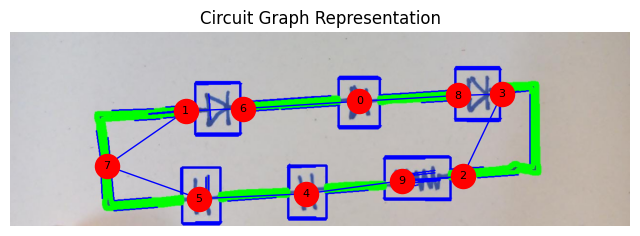


SPICE Netlist:
 


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from ultralytics import YOLO
import easyocr
from sklearn.cluster import KMeans



# Read the image
image = cv2.imread("processed_circuit.jpg")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Detect components using YOLO
results = model.predict(image)
detections = []
component_positions = []  # Store component positions to exclude from nodes

for result in results:
    if result.boxes is not None and len(result.boxes) > 0:
        boxes = result.boxes.xyxy.cpu().numpy()
        classes = result.boxes.cls.cpu().numpy()
        confidences = result.boxes.conf.cpu().numpy()
        
        for box, cls, conf in zip(boxes, classes, confidences):
            x1, y1, x2, y2 = box
            center_x, center_y = (x1 + x2) / 2, (y1 + y2) / 2
            anode_pos = (x1, center_y)
            cathode_pos = (x2, center_y)
            detections.append({
                "class": model.names[int(cls)],
                "bbox": box,
                "confidence": conf,
                "anode_pos": anode_pos,
                "cathode_pos": cathode_pos
            })
            component_positions.extend([anode_pos, cathode_pos])

# Optical Character Recognition (OCR) for text detection
reader = easyocr.Reader(['en'])
text_results = reader.readtext(image)
for text in text_results:
    text_bbox = text[0]
    text_content = text[1]
    for component in detections:
        comp_center = [(component['bbox'][0] + component['bbox'][2]) / 2,
                       (component['bbox'][1] + component['bbox'][3]) / 2]
        text_center = [(text_bbox[0][0] + text_bbox[2][0]) / 2,
                       (text_bbox[0][1] + text_bbox[2][1]) / 2]
        distance = np.linalg.norm(np.array(comp_center) - np.array(text_center))
        if distance < 50:  
            component['value'] = text_content

# Edge Detection using Canny + HoughLines
edges = cv2.Canny(gray, 50, 150)
lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=50, minLineLength=50, maxLineGap=10)

# Detect corners using Shi-Tomasi method
corners = cv2.goodFeaturesToTrack(gray, maxCorners=100, qualityLevel=0.01, minDistance=10)
corners = corners.astype(int)

# Extract wire intersection points only (Ignore component positions)
if lines is not None:
    line_points = np.array([[line[0][0], line[0][1]] for line in lines] + 
                            [[line[0][2], line[0][3]] for line in lines])
    nodes = np.vstack([corners.squeeze(), line_points])  
else:
    nodes = corners.squeeze()

# Remove nodes that are near component positions
filtered_nodes = []
for node in nodes:
    if all(np.linalg.norm(np.array(node) - np.array(pos)) > 20 for pos in component_positions):
        filtered_nodes.append(node)

filtered_nodes = np.array(filtered_nodes)

# K-means clustering to group node intersections
num_clusters = min(10, len(filtered_nodes))  # Ensure clusters < num points
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(filtered_nodes)
clustered_nodes = kmeans.cluster_centers_.astype(int)

# Graph adjacency matrix (Only using wire junctions)
G = nx.Graph()
adjacency_matrix = np.zeros((len(clustered_nodes), len(clustered_nodes)))

for line in lines:
    start_point, end_point = (line[0][0], line[0][1]), (line[0][2], line[0][3])
    start_node = np.argmin([np.linalg.norm(node - start_point) for node in clustered_nodes])
    end_node = np.argmin([np.linalg.norm(node - end_point) for node in clustered_nodes])
    adjacency_matrix[start_node][end_node] = 1
    G.add_edge(start_node, end_node)

# Assign components separately
netlist = []
for component in detections:
    anode_node = np.argmin([np.linalg.norm(node - component['anode_pos']) for node in clustered_nodes])
    cathode_node = np.argmin([np.linalg.norm(node - component['cathode_pos']) for node in clustered_nodes])
    netlist.append({
        "type": component['class'],
        "anode": anode_node,
        "cathode": cathode_node,
        "value": component.get('value', '')
    })

# Visualization using OpenCV and Matplotlib
vis_image = image.copy()
for node in clustered_nodes:
    cv2.circle(vis_image, tuple(node), 5, (0, 0, 255), -1)  # Red circles for nodes

for line in lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(vis_image, (x1, y1), (x2, y2), (255, 0, 0), 2)  # Blue lines for edges

# Show edges and vertices in OpenCV
cv2.imshow("Edges and Nodes", vis_image)

# Plot using Matplotlib and NetworkX
plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(vis_image, cv2.COLOR_BGR2RGB))
nx.draw(G, pos={i: tuple(clustered_nodes[i]) for i in range(len(clustered_nodes))},
        with_labels=True, node_color='red', edge_color='blue', font_size=8)
plt.title("Circuit Graph Representation")
plt.show()

# Generate SPICE Netlist
spice_netlist = "\n".join([f"{c['type']} {c['anode']} {c['cathode']} {c['value']}" for c in netlist])
print("\nSPICE Netlist:\n", spice_netlist)

cv2.waitKey(0)
cv2.destroyAllWindows()


# LOAD A PREDEFINED YOLO MODEL

In [ ]:
# Load YOLOv8 model (pretrained on custom dataset)
model = YOLO("yolov8n.pt")